# Part 4: Models (Continued)

# Import Necessary Libraries

In [1]:
# System
import pathlib
import glob
import os, os.path, shutil
# Data Exploration
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import seaborn as sns
from PIL import Image
# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
#Deep Learning
import tensorflow as tf
import keras
from keras.utils import plot_model ######
from keras import backend as K ##########
from keras import metrics
from keras.regularizers import l2,l1
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img, load_img
from keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Something unknown :)
import pydot
from dask import bag,  diagnostics
from mlxtend.plotting import plot_confusion_matrix

# Data Directory

In [2]:
train_dir = 'split/train'
train_CORROSION_dir = 'split/train/CORROSION/'
train_NOCORROSION_dir = 'split/train/NOCORROSION/'

validation_dir = 'split/validation'
validation_CORROSION_dir = 'split/validation/CORROSION/'
validation_NOCORROSION_dir = 'split/validation/NOCORROSION/'

test_dir = 'split/test'
test_CORROSION_dir = 'split/test/CORROSION/'
test_NOCORROSION_dir = 'split/test/NOCORROSION/'

In [3]:
def num_files_in_direcotry(path):
    num = len([file for file in os.listdir(path) if file.endswith('.jpg')])
    return num

In [4]:
train_CORROSION_num = num_files_in_direcotry(train_CORROSION_dir)
train_NOCORROSION_num = num_files_in_direcotry(train_NOCORROSION_dir)
train_SUM_num = train_CORROSION_num + train_NOCORROSION_num

print("[Train] Number of CORROSION Images: ", train_CORROSION_num)
print("[Train] Number of NOCORROSION Images: ", train_NOCORROSION_num)
print("[Train] Number of TOTAL Images: ", train_SUM_num)

[Train] Number of CORROSION Images:  693
[Train] Number of NOCORROSION Images:  580
[Train] Number of TOTAL Images:  1273


In [5]:
val_CORROSION_num = num_files_in_direcotry(validation_CORROSION_dir)
val_NOCORROSION_num = num_files_in_direcotry(validation_NOCORROSION_dir)
val_SUM_num = val_CORROSION_num + val_NOCORROSION_num

print("[Validation] Number of CORROSION Images: ", val_CORROSION_num)
print("[Validation] Number of NOCORROSION Images: ", val_NOCORROSION_num)
print("[Validation] Number of TOTAL Images: ", val_SUM_num)

[Validation] Number of CORROSION Images:  198
[Validation] Number of NOCORROSION Images:  166
[Validation] Number of TOTAL Images:  364


In [6]:
test_CORROSION_num = num_files_in_direcotry(test_CORROSION_dir)
test_NOCORROSION_num = num_files_in_direcotry(test_NOCORROSION_dir)
test_SUM_num = test_CORROSION_num + test_NOCORROSION_num

print("[Test] Number of CORROSION Images: ", test_CORROSION_num)
print("[Test] Number of NOCORROSION Images: ", test_NOCORROSION_num)
print("[Test] Number of TOTAL Images: ", test_SUM_num)

[Test] Number of CORROSION Images:  99
[Test] Number of NOCORROSION Images:  83
[Test] Number of TOTAL Images:  182


# Function for results visualization

In [7]:
def create_charts(cnn, cnn_model):
    """
    plot1: train & validatoin loss curves
    plot2: train & validatoin accuracy curves
    Plot3: confusion matrix
    Plot4: train & validation ROC curve and AUC score
    Summary Statistics
    
    """
    
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation accuracy
    train_auc = cnn_model.history['acc']
    val_auc = cnn_model.history['val_acc']
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION Accuracy
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  
    names = ['True Positives', 'False Negatives', 'False Positives', 'True Negatives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['CORROSION', 'NOCORROSION']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    ## Summary Statistics
    TP, FN, FP, TN = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [ ]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

In [9]:
# Build data generator function

def make_data_generator(
    train_datagen, train_dir, 
    val_datagen, val_dir, 
    test_datagen, test_dir):
    
    datagen_lst = [train_datagen, val_datagen, test_datagen]
    directory_lst = [train_dir, val_dir, test_dir]
    generator_lst = []
    for generator, directory in zip(datagen_lst, directory_lst):
        if directory == train_dir:
            shuffle = True
        else:
            shuffle = False
        g = generator.flow_from_directory(directory = directory,
                                         target_size = (128,128),
                                         batch_size = 32,
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         shuffle = shuffle,
                                         seed = 42)
        generator_lst.append(g)
    
    return generator_lst

In [10]:
# Load the images

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   vertical_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator,val_generator, test_generator = make_data_generator(
    train_datagen, train_dir,
    val_datagen, validation_dir,
    test_datagen, test_dir)

Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


# Model 10: New architecture

In [11]:
 # Design the model
    
def build_model_New_1():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2))))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
#    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New_1 = build_model_New_1()

In [12]:
cnn_model_New_1 = cnn_New_1.fit_generator(train_generator,
                              epochs = 30,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
40/40 [==============================] - 26s 634ms/step - loss: 0.6840 - acc: 0.5737 - val_loss: 0.6323 - val_acc: 0.7418
Epoch 2/30
40/40 [==============================] - 24s 611ms/step - loss: 0.6002 - acc: 0.7220 - val_loss: 0.5570 - val_acc: 0.7390
Epoch 3/30
40/40 [==============================] - 24s 610ms/step - loss: 0.5924 - acc: 0.7222 - val_loss: 0.5240 - val_acc: 0.7473
Epoch 4/30
40/40 [==============================] - 24s 603ms/step - loss: 0.5012 - acc: 0.7690 - val_loss: 0.4966 - val_acc: 0.7747
Epoch 5/30
40/40 [==============================] - 24s 607ms/step - loss: 0.4872 - acc: 0.7994 - val_loss: 0.6576 - val_acc: 0.7115
Epoch 6/30
40/40 [==============================] - 25s 613ms/step - loss: 0.5016 - acc: 0.7825 - val_loss: 0.4755 - val_acc: 0.7995
Epoch 7/30
40/40 [==============================] - 25s 613ms/step - loss: 0.4521 - acc: 0.7979 - val_loss: 0.4792 - val_acc: 0.7912
Epoch 8/30
40/40 [==============================] - 24s 609ms/step - 

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 79.67% | Precision = 90.79% | Recall = 69.70% | Specificity = 91.57% | F1 Score = 78.86%


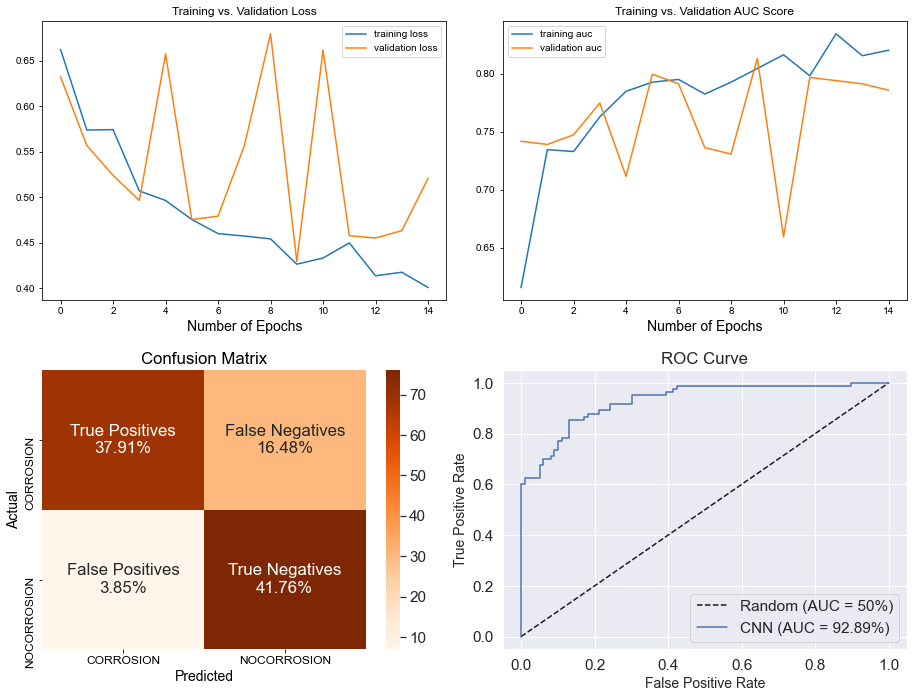

In [13]:
create_charts(cnn_New_1,cnn_model_New_1)

# Model 11: New architecture, Dropout

In [14]:
 # Design the model
    
def build_model_New_2():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New_2 = build_model_New_2()

In [15]:
cnn_model_New_2 = cnn_New_2.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 25s 623ms/step - loss: 0.7114 - acc: 0.5074 - val_loss: 0.6715 - val_acc: 0.6896
Epoch 2/100
40/40 [==============================] - 24s 605ms/step - loss: 0.6756 - acc: 0.5443 - val_loss: 0.6378 - val_acc: 0.6209
Epoch 3/100
40/40 [==============================] - 24s 611ms/step - loss: 0.6158 - acc: 0.6792 - val_loss: 0.6339 - val_acc: 0.6538
Epoch 4/100
40/40 [==============================] - 24s 611ms/step - loss: 0.5751 - acc: 0.7344 - val_loss: 0.5848 - val_acc: 0.7335
Epoch 5/100
40/40 [==============================] - 24s 608ms/step - loss: 0.5256 - acc: 0.7373 - val_loss: 0.5171 - val_acc: 0.7555
Epoch 6/100
40/40 [==============================] - 24s 618ms/step - loss: 0.4879 - acc: 0.7779 - val_loss: 0.5079 - val_acc: 0.7747
Epoch 7/100
40/40 [==============================] - 25s 625ms/step - loss: 0.4402 - acc: 0.8130 - val_loss: 0.4826 - val_acc: 0.7637
Epoch 8/100
40/40 [==============================] - 24s 606ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 85.16% | Precision = 83.96% | Recall = 89.90% | Specificity = 79.52% | F1 Score = 86.83%


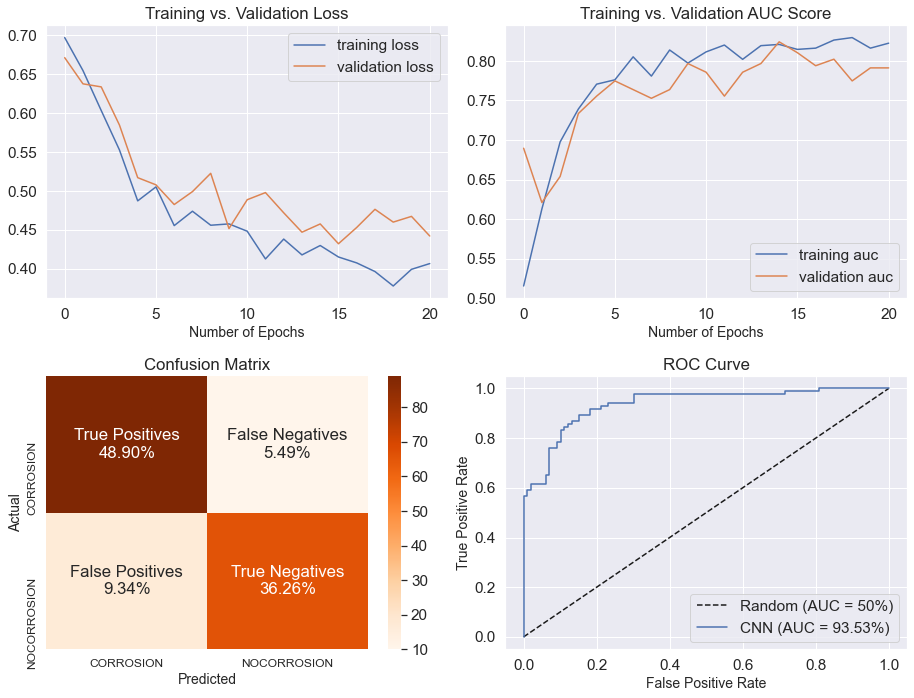

In [16]:
create_charts(cnn_New_2,cnn_model_New_2)

# Model 12: New architecture, L2 regulations

In [17]:
 # Design the model
    
def build_model_New_3():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))

    cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer =keras.regularizers.l2( l=0.01)))
    cnn.add(MaxPooling2D((2, 2)))

    
    cnn.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer =keras.regularizers.l2( l=0.01)))
    cnn.add(MaxPooling2D((2, 2)))

    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu', kernel_regularizer =keras.regularizers.l2( l=0.01)))
#    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New_3 = build_model_New_3()

In [19]:
cnn_model_New_3 = cnn_New_3.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

Epoch 1/100
40/40 [==============================] - 25s 627ms/step - loss: 8.2026 - acc: 0.7565 - val_loss: 8.2828 - val_acc: 0.7527
Epoch 2/100
40/40 [==============================] - 25s 623ms/step - loss: 8.2961 - acc: 0.7863 - val_loss: 8.3811 - val_acc: 0.7885
Epoch 3/100
40/40 [==============================] - 25s 630ms/step - loss: 8.4639 - acc: 0.7659 - val_loss: 8.5973 - val_acc: 0.7363
Epoch 4/100
40/40 [==============================] - 25s 614ms/step - loss: 8.6631 - acc: 0.7636 - val_loss: 8.7435 - val_acc: 0.7857
Epoch 5/100
40/40 [==============================] - 26s 645ms/step - loss: 8.8001 - acc: 0.7793 - val_loss: 8.9695 - val_acc: 0.7610
Epoch 6/100
40/40 [==============================] - 26s 654ms/step - loss: 9.0034 - acc: 0.7612 - val_loss: 9.1103 - val_acc: 0.7720
Epoch 00006: early stopping


/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 80.77% | Precision = 84.78% | Recall = 78.79% | Specificity = 83.13% | F1 Score = 81.68%


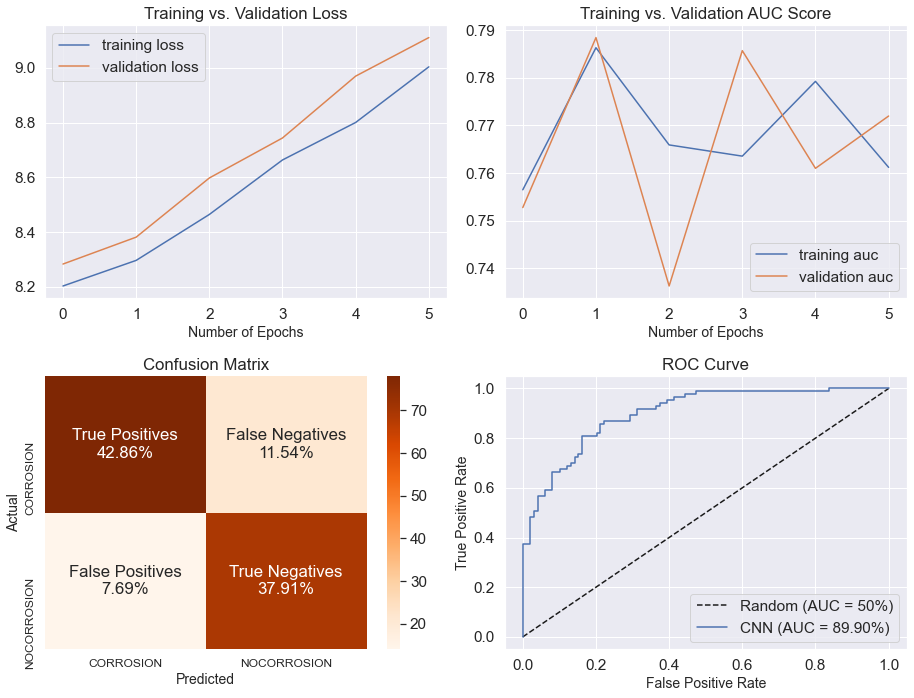

In [20]:
create_charts(cnn_New_3,cnn_model_New_3)

# Model 13: New architecture, Dropput

In [21]:
 # Design the model
    
def build_model_New_4():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.25))
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.25))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New_4 = build_model_New_4()

In [22]:
cnn_model_New_4 = cnn_New_4.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 27s 665ms/step - loss: 0.7123 - acc: 0.5163 - val_loss: 0.6689 - val_acc: 0.6676
Epoch 2/100
40/40 [==============================] - 26s 642ms/step - loss: 0.6605 - acc: 0.6396 - val_loss: 0.6166 - val_acc: 0.6868
Epoch 3/100
40/40 [==============================] - 26s 638ms/step - loss: 0.5964 - acc: 0.6755 - val_loss: 0.5955 - val_acc: 0.7170
Epoch 4/100
40/40 [==============================] - 26s 636ms/step - loss: 0.5481 - acc: 0.7491 - val_loss: 0.5801 - val_acc: 0.7308
Epoch 5/100
40/40 [==============================] - 26s 638ms/step - loss: 0.5234 - acc: 0.7576 - val_loss: 0.5527 - val_acc: 0.7555
Epoch 6/100
40/40 [==============================] - 26s 636ms/step - loss: 0.5258 - acc: 0.7524 - val_loss: 0.5266 - val_acc: 0.7582
Epoch 7/100
40/40 [==============================] - 26s 644ms/step - loss: 0.4873 - acc: 0.7791 - val_loss: 0.5354 - val_acc: 0.7912
Epoch 8/100
40/40 [==============================] - 26s 646ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 83.52% | Precision = 91.57% | Recall = 76.77% | Specificity = 91.57% | F1 Score = 83.52%


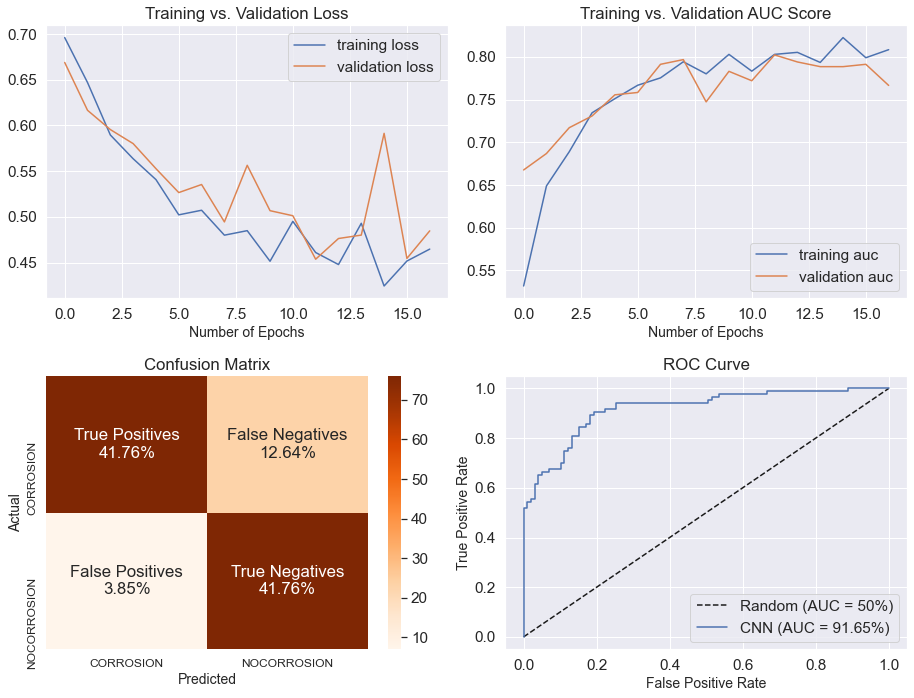

In [23]:
create_charts(cnn_New_4,cnn_model_New_4)

In [24]:
 # Design the model
    
def build_model_New_5():
    cnn = Sequential()

    cnn.add(InputLayer(input_shape=(128, 128, 3)))

    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.1))
    
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Dropout(0.2))
    

    cnn.add(Flatten())
            
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dense(1, activation='sigmoid'))
    
    # Compile
    cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    return cnn

cnn_New_5 = build_model_New_5()

In [25]:
cnn_model_New_5 = cnn_New_5.fit_generator(train_generator,
                              epochs = 100,
                              steps_per_epoch = len(train_generator),
                              validation_data = val_generator,
                              validation_steps = len(val_generator),
                              verbose = 1,
                              callbacks=[es])

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
40/40 [==============================] - 27s 658ms/step - loss: 0.7116 - acc: 0.5324 - val_loss: 0.6785 - val_acc: 0.5440
Epoch 2/100
40/40 [==============================] - 26s 637ms/step - loss: 0.6574 - acc: 0.5883 - val_loss: 0.6326 - val_acc: 0.6319
Epoch 3/100
40/40 [==============================] - 26s 640ms/step - loss: 0.6319 - acc: 0.6499 - val_loss: 0.5790 - val_acc: 0.7060
Epoch 4/100
40/40 [==============================] - 26s 641ms/step - loss: 0.5671 - acc: 0.7196 - val_loss: 0.5722 - val_acc: 0.7390
Epoch 5/100
40/40 [==============================] - 26s 642ms/step - loss: 0.5244 - acc: 0.7473 - val_loss: 0.5425 - val_acc: 0.7363
Epoch 6/100
40/40 [==============================] - 26s 647ms/step - loss: 0.4972 - acc: 0.7659 - val_loss: 0.5669 - val_acc: 0.7115
Epoch 7/100
40/40 [==============================] - 26s 641ms/step - loss: 0.5010 - acc: 0.7639 - val_loss: 0.5157 - val_acc: 0.7473
Epoch 8/100
40/40 [==============================] - 26s 637ms

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[Summary Statistics]
Accuracy = 86.81% | Precision = 85.05% | Recall = 91.92% | Specificity = 80.72% | F1 Score = 88.35%


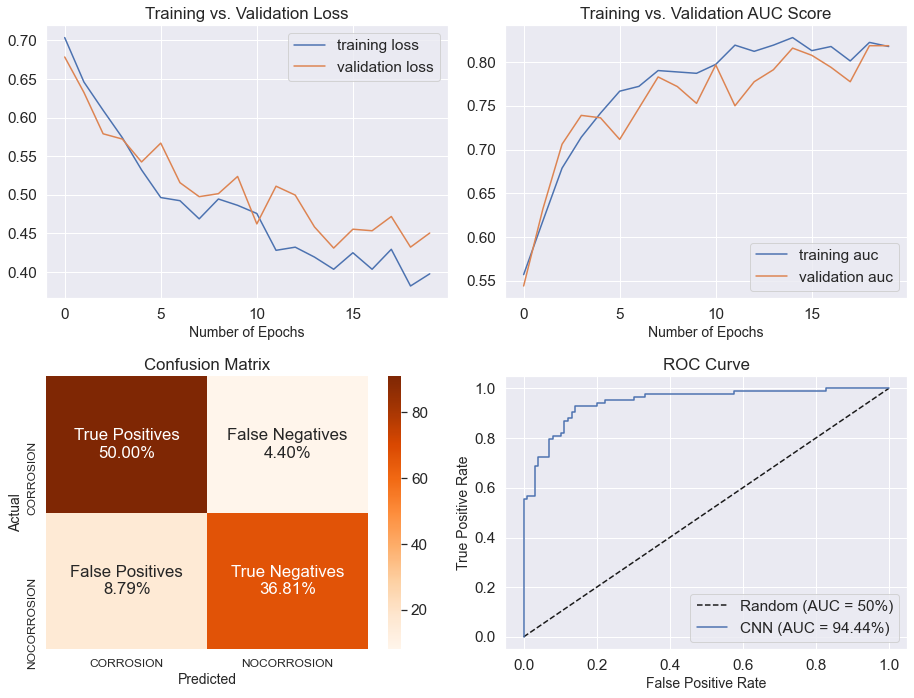

In [26]:
create_charts(cnn_New_5,cnn_model_New_5)

In [31]:
saved_model_path = 'test_model_weights/saved_model.h5'

In [33]:
cnn_New_5.save(saved_model_path)

/Users/pengjusun/miniforge3/envs/New-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


([<matplotlib.axis.YTick at 0x2d110baf0>,
 [Text(0, 0, 'CORROSION'), Text(0, 1, 'NOCORROSION')])

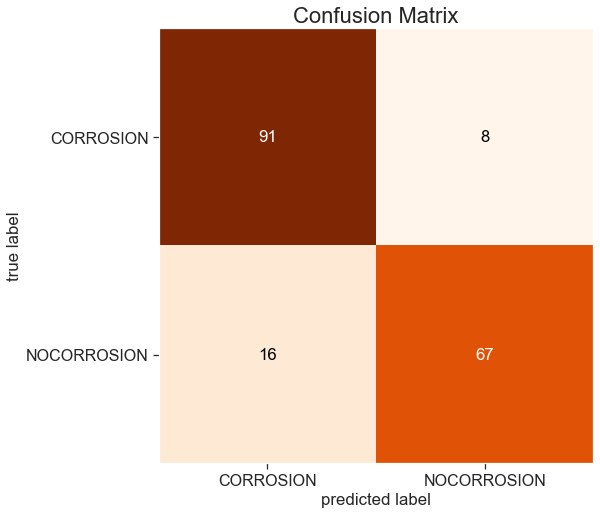

In [30]:
y_true = test_generator.classes
Y_pred = cnn_New_5.predict_generator(test_generator, steps = len(test_generator))
y_pred = (Y_pred > 0.5).T[0]
y_pred_prob = Y_pred.T[0]
cm = confusion_matrix(y_true,y_pred)
plot_confusion_matrix(cm, figsize = (12,8), hide_ticks = True, cmap = plt.cm.Oranges)
plt.title("Confusion Matrix", fontsize = 22) 
plt.xticks(range(2), ['CORROSION','NOCORROSION'], fontsize = 16)
plt.yticks(range(2), ['CORROSION','NOCORROSION'], fontsize = 16)

The above model is our best performance model so far. The model early stopped at epoch number 20 (total epoch number = 100) when the chosen performance (minimize loss) stopped improving. We can account for this by adding a delay to the trigger in terms of the number of epochs we would like to see no improvement. This can be done by setting the "patience." In this case, I set patience = 7.

As you can see, as the number of epoch increases, the lines of validation loss and training loss approach each other, which means that our model doesn't seem to have much overfitting or underfitting. For the chart on the right, the line of training and validation accuracy score converges to a point where they are almost equal in the end.

Our test set yields an AUC score of 94.44%, which indicates that our best performance CNN model does a great job at ranking the data by its class in the test set.

We aim to have a high recall number for detecting corrosion as any missed corrosion problem or delayed treatment could lead to catastrophic failure of the structures that cause loss of assets or even human life. Our best performance model achieves 92% for recall, which did an excellent job of detecting corrosion. The confusion matrix shows that our model correctly classified 91 out of 99 corrosion images in the test set. At the same time, the false positives and false negatives are 8.79% and 4.4%, which also shows that our model did a decent job in detecting whether an image contains corrosion or not.